In [138]:
import os
import pandas as pd
import numpy as np
np.random.seed(42)
import requests, zipfile, io
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50
import random
random.seed(42)

In [139]:
r= requests.get('https://ti.arc.nasa.gov/c/6/', stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [140]:
train = pd.read_csv('train_FD001.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)
test = pd.read_csv('test_FD001.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)
RUL = pd.read_csv('RUL_FD001.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)

In [141]:
RUL.head(5)

,0,1
0,112,nan
1,98,nan
2,69,nan
3,82,nan
4,91,nan


In [142]:
train.columns[train.isnull().sum() > 0]

Int64Index([26, 27], dtype='int64')

In [143]:
train.drop(train.columns[[26, 27]], axis=1, inplace=True)
test.drop(test.columns[[26,27]], axis=1, inplace=True)

In [144]:
cols = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
train.columns = cols
test.columns = cols

In [178]:
train.groupby('unit')['cycles'].median().describe()

count   100.000
mean    103.655
std      23.171
min      64.500
25%      89.000
50%     100.000
75%     115.125
max     181.500
Name: cycles, dtype: float64

In [146]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,20631.000,51.507,29.228,1.000,26.000,52.000,77.000,100.000
cycles,20631.000,108.808,68.881,1.000,52.000,104.000,156.000,362.000
op_setting1,20631.000,-0.000,0.002,-0.009,-0.002,0.000,0.002,0.009
op_setting2,20631.000,0.000,0.000,-0.001,-0.000,0.000,0.000,0.001
op_setting3,20631.000,100.000,0.000,100.000,100.000,100.000,100.000,100.000
s1,20631.000,518.670,0.000,518.670,518.670,518.670,518.670,518.670
s2,20631.000,642.681,0.500,641.210,642.325,642.640,643.000,644.530
s3,20631.000,1590.523,6.131,1571.040,1586.260,1590.100,1594.380,1616.910
s4,20631.000,1408.934,9.001,1382.250,1402.360,1408.040,1414.555,1441.490
s5,20631.000,14.620,0.000,14.620,14.620,14.620,14.620,14.620


In [147]:
train.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)
test.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)

In [148]:
cyclestrain = train.groupby('unit', as_index=False)['cycles'].max()
cyclestest = test.groupby('unit', as_index=False)['cycles'].max()

In [149]:
train = pd.merge(train, train.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')

In [150]:
train.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)

In [151]:
train['TTF'] = train['maxcycles'] - train['cycles']

In [172]:
train['maxcycles'].describe()

count   20631.000
mean      216.616
std        50.029
min       128.000
25%       185.000
50%       207.000
75%       240.000
max       362.000
Name: maxcycles, dtype: float64

In [152]:
train.TTF

0        191
1        190
2        189
3        188
4        187
        ... 
20626      4
20627      3
20628      2
20629      1
20630      0
Name: TTF, Length: 20631, dtype: int64

In [153]:
scaler = MinMaxScaler()

In [154]:
ntrain = train.copy()

In [155]:
ntrain.iloc[:,2:19] = scaler.fit_transform(ntrain.iloc[:,2:19])

In [156]:
ntest = test.copy()

In [157]:
ntest.iloc[:,2:19] = scaler.transform(ntest.iloc[:,2:19])

In [158]:
def fractionTTF(dat,q):
    return(dat.TTF[q]-dat.TTF.min()) / float(dat.TTF.max()-dat.TTF.min())

In [159]:
fTTFz = []
fTTF = []

for i in range(train['unit'].min(),train['unit'].max()+1):
    dat=train[train.unit==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)
ntrain['fTTF'] = fTTF

In [160]:
ntrain['fTTF'].describe()

count   20631.000
mean        0.500
std         0.290
min         0.000
25%         0.249
50%         0.500
75%         0.751
max         1.000
Name: fTTF, dtype: float64

In [161]:
X_train = ntrain.values[:,2:19]
Y_train = ntrain.values[:, 21]
X_test = ntest.values[:,2:19]

In [162]:
ntrain.head(5)

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,maxcycles,TTF,fTTF
0,1,1,0.460,0.167,0.184,0.407,0.310,1.000,0.726,0.242,...,0.633,0.206,0.200,0.364,0.333,0.713,0.725,192,191,1.000
1,1,2,0.609,0.250,0.283,0.453,0.353,1.000,0.628,0.212,...,0.765,0.279,0.163,0.411,0.333,0.667,0.731,192,190,0.995
2,1,3,0.253,0.750,0.343,0.370,0.371,1.000,0.710,0.273,...,0.795,0.221,0.172,0.357,0.167,0.628,0.621,192,189,0.990
3,1,4,0.540,0.500,0.343,0.256,0.331,1.000,0.741,0.318,...,0.889,0.294,0.175,0.167,0.333,0.574,0.662,192,188,0.984
4,1,5,0.391,0.333,0.349,0.257,0.405,1.000,0.668,0.242,...,0.746,0.235,0.175,0.402,0.417,0.589,0.705,192,187,0.979


In [163]:
model = Sequential()
model.add(Dense(6, input_dim=17, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, Y_train, epochs=20)

Epoch 1/20
645/645 [==============================] - 0s 743us/step - loss: 0.0510
Epoch 2/20
645/645 [==============================] - 0s 743us/step - loss: 0.0283
Epoch 3/20
645/645 [==============================] - 0s 747us/step - loss: 0.0262
Epoch 4/20
645/645 [==============================] - 0s 747us/step - loss: 0.0254
Epoch 5/20
645/645 [==============================] - 0s 746us/step - loss: 0.0250
Epoch 6/20
645/645 [==============================] - 0s 746us/step - loss: 0.0248
Epoch 7/20
645/645 [==============================] - 0s 746us/step - loss: 0.0247
Epoch 8/20
645/645 [==============================] - 0s 747us/step - loss: 0.0246
Epoch 9/20
645/645 [==============================] - 0s 748us/step - loss: 0.0246
Epoch 10/20
645/645 [==============================] - 0s 746us/step - loss: 0.0246
Epoch 11/20
645/645 [==============================] - 0s 746us/step - loss: 0.0245
Epoch 12/20
645/645 [==============================] - 0s 745us/step - loss: 0.0245
E

In [164]:
score = model.predict(X_test)

In [165]:
test = pd.merge(test, test.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
test.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
test['score'] = score

In [166]:
def totcycles(data):
    return(data['cycles'] / (1-data['score']))
    
test['maxpredcycles'] = totcycles(test)

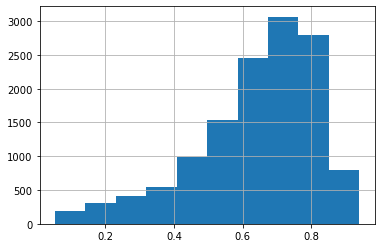

In [167]:
test['score'].hist()

In [88]:
test.loc[test['unit']==4]

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s14,s15,s17,s20,s21,maxcycles,score,maxpredcycles,RUL,maxcycles
206,4,1,-0.002,0.000,642.630,1589.430,1399.930,21.610,553.100,2388.050,...,8131.610,8.419,393,38.880,23.320,106,0.869,7.610,-226.557,106
207,4,2,-0.000,0.001,642.360,1591.830,1406.260,21.610,553.610,2388.110,...,8132.510,8.410,392,38.950,23.306,106,0.870,15.347,-307.026,106
208,4,3,0.002,0.000,642.580,1590.840,1409.670,21.610,554.280,2388.080,...,8137.190,8.425,391,38.630,23.381,106,0.862,21.785,-978.541,106
209,4,4,-0.001,-0.000,642.590,1589.020,1402.180,21.610,553.570,2388.110,...,8128.100,8.421,392,38.940,23.322,106,0.861,28.736,335.468,106
210,4,5,0.000,0.000,642.290,1584.920,1410.310,21.610,553.420,2388.070,...,8135.370,8.431,391,38.890,23.293,106,0.859,35.507,156.405,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,4,102,-0.001,-0.000,642.690,1588.870,1418.380,21.610,553.930,2388.030,...,8134.150,8.416,393,38.830,23.216,106,0.509,207.814,86.379,106
308,4,103,0.003,-0.000,642.930,1594.260,1414.050,21.610,553.070,2388.090,...,8134.720,8.466,393,38.840,23.259,106,0.484,199.663,79.562,106
309,4,104,-0.001,-0.000,642.850,1588.920,1406.160,21.610,553.530,2388.150,...,8133.940,8.465,392,38.870,23.252,106,0.489,203.375,80.762,106
310,4,105,-0.003,-0.000,642.680,1593.010,1408.210,21.610,554.050,2388.180,...,8135.190,8.450,395,38.670,23.273,106,0.463,195.378,70.479,106
